# 1. Carga de librerias y dataset

Hice unos cambios en el datset, puse todos los nombres de las columnas en minuscula, saque acentos y cambie espacios vacios por guiones bajos

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Cargo dataset y borro primer columna por ser ID que no me sirven
data = pd.read_excel("/content/gdrive/MyDrive/DATA SCIENCE/base_def3.xlsx")

data.drop(columns="idalumno", inplace=True)



# 2. Analisis general 

### 2.1 Creo categorias binarias

In [3]:
# creo grupo de Abandono y No Abandono como target

data.situacion = data.situacion.replace({"NoRegular": "Abandono",
                                         "Baja": "Abandono",
                                         "Activo": "No Abandono",
                                         "Egresado" : "No Abandono"})

In [4]:
# Observo la nueva clasificacione de las categorias y un pantallazo de los datos
data.head()


,sexo,edad_inicio,anefm,situacion,anios_recibirse,anio_ultmateria,n_internado_anual_rotatorio,nota_iar,n_anatomia,nota_anatomia,...,n_salud_mental,nota_salud_mental,n_salud_publica_i,nota_salud_publica_i,n_salud_publica_ii,nota_salud_publica_ii,n_tisioneumonologia,nota_tisioneumonologia,n_toxicologia,nota_toxicologia
0,M,20.0,0,Abandono,No recibido,2012,0,NaN,3,7.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,F,20.0,2015,No Abandono,7,2014,1,0P,1,7.0,...,1,7.0,1,8.0,1,9.0,1,8.0,1,7.0
2,M,20.0,2015,No Abandono,7,2014,1,0P,1,8.0,...,1,10.0,1,8.0,1,7.0,1,10.0,1,9.0
3,M,20.0,0,No Abandono,No recibido,2019,3,NaN,1,5.0,...,2,5.0,1,7.0,1,5.0,1,8.0,1,8.0
4,F,20.0,2015,No Abandono,7,2015,1,0P,1,8.0,...,1,9.0,1,8.0,1,7.0,1,8.0,1,8.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756 entries, 0 to 1755
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   sexo                                 1756 non-null   object 
 1   edad_inicio                          1737 non-null   float64
 2   anefm                                1756 non-null   int64  
 3   situacion                            1756 non-null   object 
 4   anios_recibirse                      1756 non-null   object 
 5   anio_ultmateria                      1756 non-null   int64  
 6   n_internado_anual_rotatorio          1756 non-null   int64  
 7   nota_iar                             1215 non-null   object 
 8   n_anatomia                           1756 non-null   int64  
 9   nota_anatomia                        1498 non-null   float64
 10  n_bioetica_i                         1756 non-null   int64  
 11  nota_bioetica_i               

### 2.2 Missing Values

In [6]:
data.isna().sum()/data.shape[0]*100

sexo                       0.000000
edad_inicio                1.082005
anefm                      0.000000
situacion                  0.000000
anios_recibirse            0.000000
                            ...    
nota_salud_publica_ii     28.302961
n_tisioneumonologia        0.000000
nota_tisioneumonologia    28.815490
n_toxicologia              0.000000
nota_toxicologia          29.612756
Length: 82, dtype: float64

### 2.3 Elimino columnas que no me sirven

In [7]:
# limpio columnas que no creo necesarias como años que tardo en recibirse, año de ultima materia, iar, y n_iar y anefm, nota iar

data.drop(columns=["anefm", "anios_recibirse", "anio_ultmateria", "n_internado_anual_rotatorio", "nota_iar"], inplace=True)

### 2.4 Paso a numerica la variable sexo

In [8]:
# Paso a numericas variable sexo
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#Sexo --> M= 1, F=0
data.sexo = le.fit_transform(data.sexo)

### 2.5 Limpio Nan y creo 3 categorias para mejor estudio

In [9]:
# Separo para mejor visualizacion en tres categorias.

nota_data = data.filter(like="nota_")           
n_data = data.filter(like="n_")
sexo_edad_data = data.loc[:, ["sexo", "edad_inicio"]]

In [10]:
# Reemplazo con 0 las filas de nota que no tenian ningun intento.

for n, nota in zip(n_data, nota_data):
    mask_zero = data[n].loc[data[n] == 0]
    data[nota].fillna(mask_zero, inplace=True)

In [11]:
# Elimino las filas que son nulos 
data.dropna(inplace=True)

In [12]:
# Observo los valores nulos que quedaron
data.isna().any().value_counts()

False    77
dtype: int64

In [13]:
# Vuelvo a separar target de las otras variables ya sin NaN

nota_data = data.filter(like="nota_")           
n_data = data.filter(like="n_")
sexo_edad_data = data.loc[:, ["sexo", "edad_inicio"]]

### 2.6 Separo target de las otras variables

In [14]:
data_x = data.drop(columns="situacion")
data_y = data["situacion"]

# 3. Analisis Target

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


El 19.98 de los target totales son Abandono


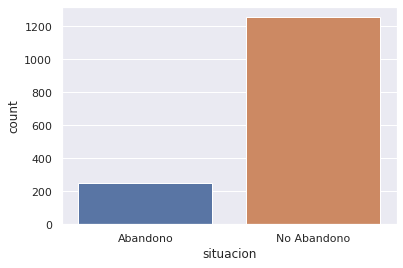

In [15]:
sns.countplot(data_y)
print(f"El {round(data_y.value_counts()[1]/data_y.value_counts()[0]*100,2)} de los target totales son Abandono")

In [16]:
data_y_dummie = pd.get_dummies(data_y, drop_first=True)

# 4. Analisis de features

In [17]:
data_x.describe().T

,count,mean,std,min,25%,50%,75%,max
sexo,1507.0,0.315859,0.465012,0.0,0.0,0.0,1.0,1.0
edad_inicio,1507.0,20.298607,1.534384,19.0,19.0,20.0,21.0,47.0
n_anatomia,1507.0,1.082946,0.619853,0.0,1.0,1.0,1.0,5.0
nota_anatomia,1507.0,5.737226,2.438342,0.0,5.0,6.0,7.0,10.0
n_bioetica_i,1507.0,0.881885,0.344734,0.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...
nota_salud_publica_ii,1507.0,6.081619,3.150177,0.0,6.0,7.0,8.0,10.0
n_tisioneumonologia,1507.0,0.834771,0.440224,0.0,1.0,1.0,1.0,3.0
nota_tisioneumonologia,1507.0,6.057731,3.259879,0.0,5.0,7.0,8.0,10.0
n_toxicologia,1507.0,0.826145,0.437646,0.0,1.0,1.0,1.0,3.0


### 4.1 Correlacion

In [18]:
# Creo funcion para heatmap de corr

import seaborn as sns; sns.set_theme()

def corr_heatmap(data, target):
    data_dummie = pd.concat([target, data], axis=1)
    corr =data_dummie.corr()
    fig,ax = plt.subplots(figsize=(17,17))
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    matrix = np.triu(corr)
    sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=cmap, mask=matrix)

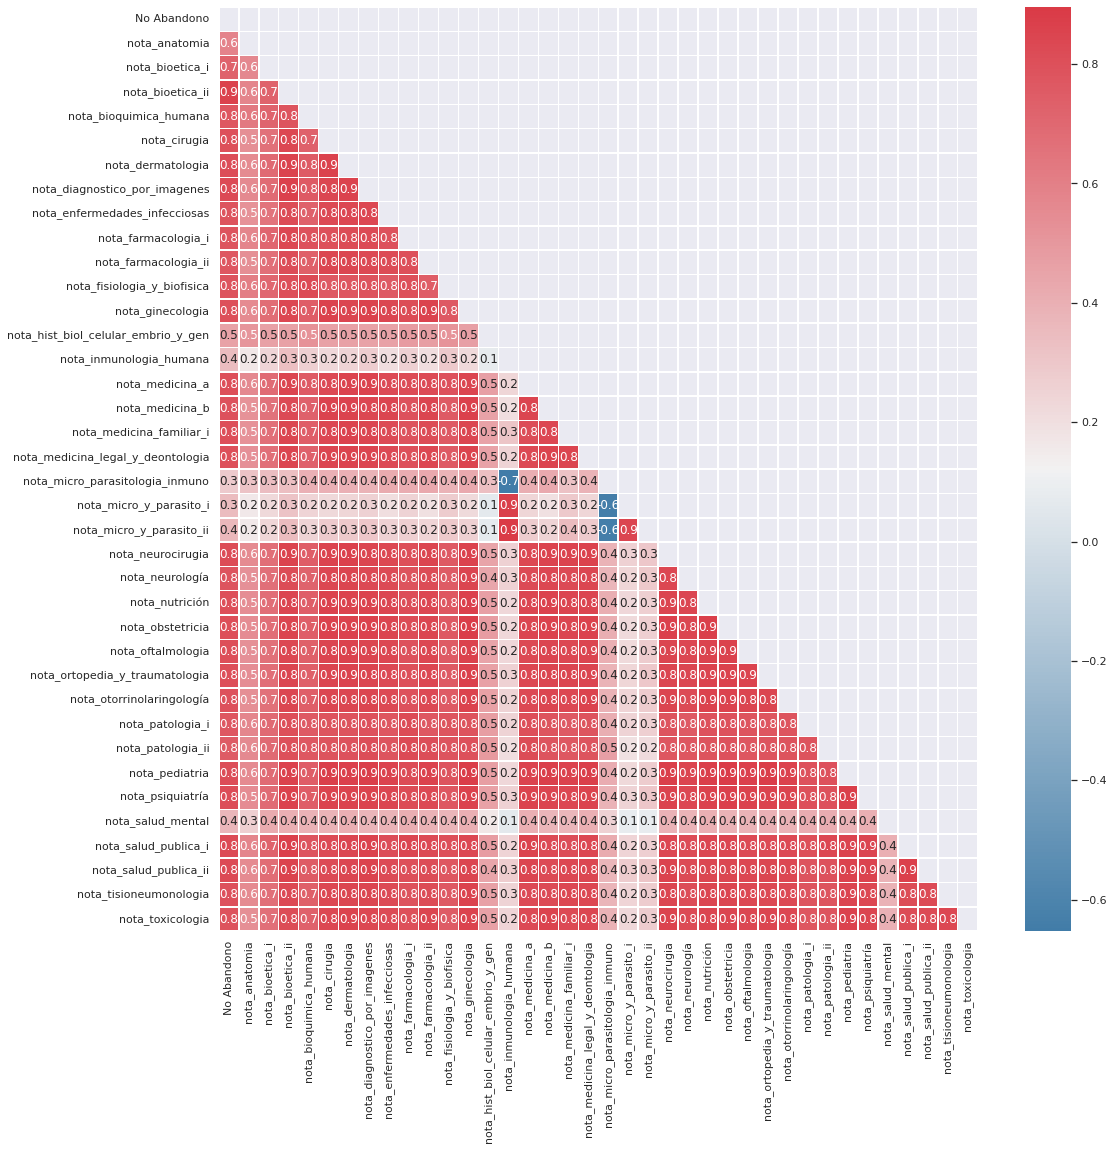

In [19]:
corr_heatmap(nota_data, data_y_dummie)

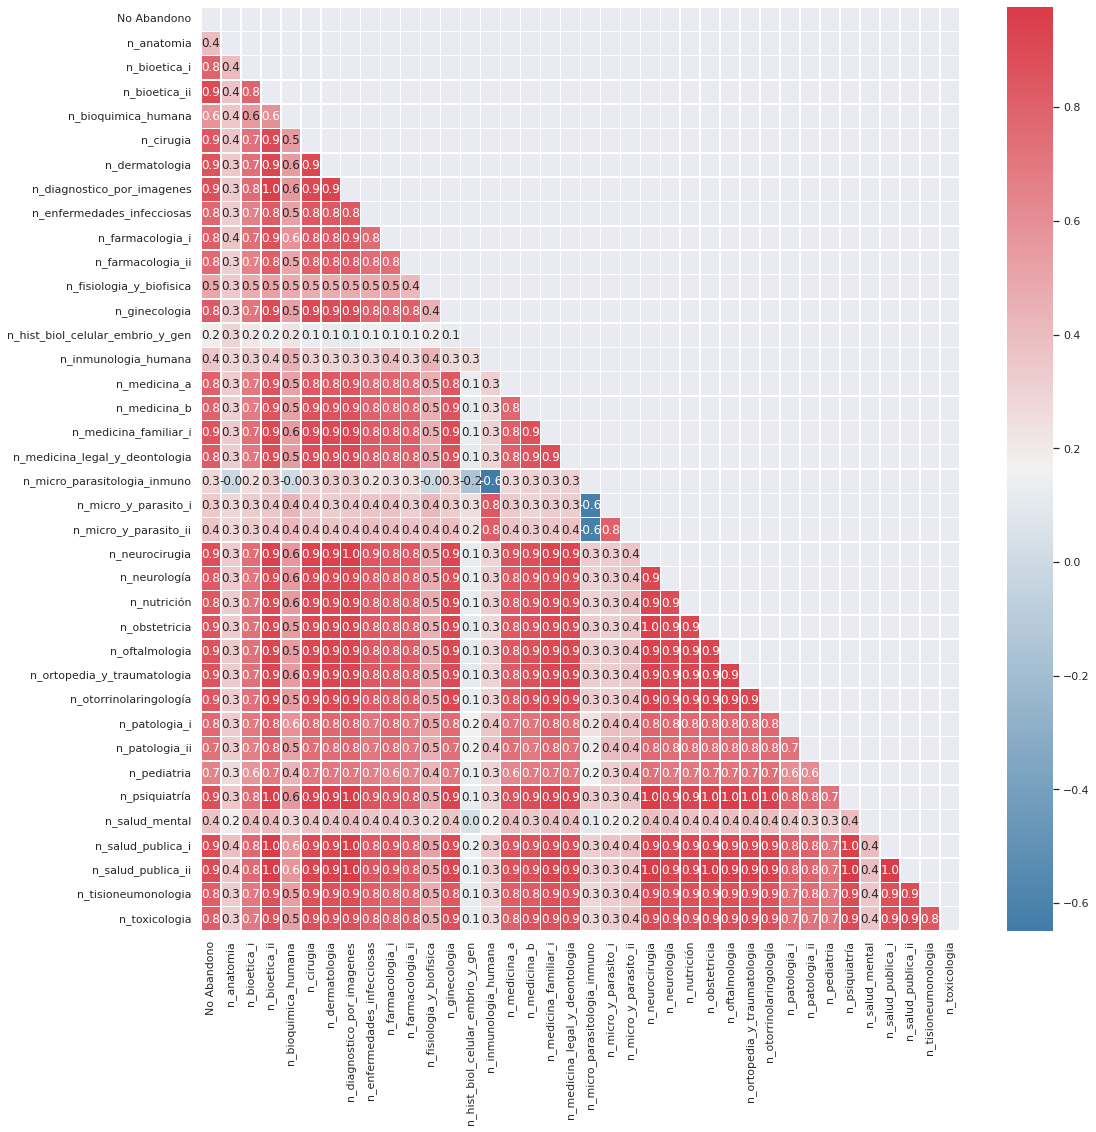

In [20]:
corr_heatmap(n_data, data_y_dummie)

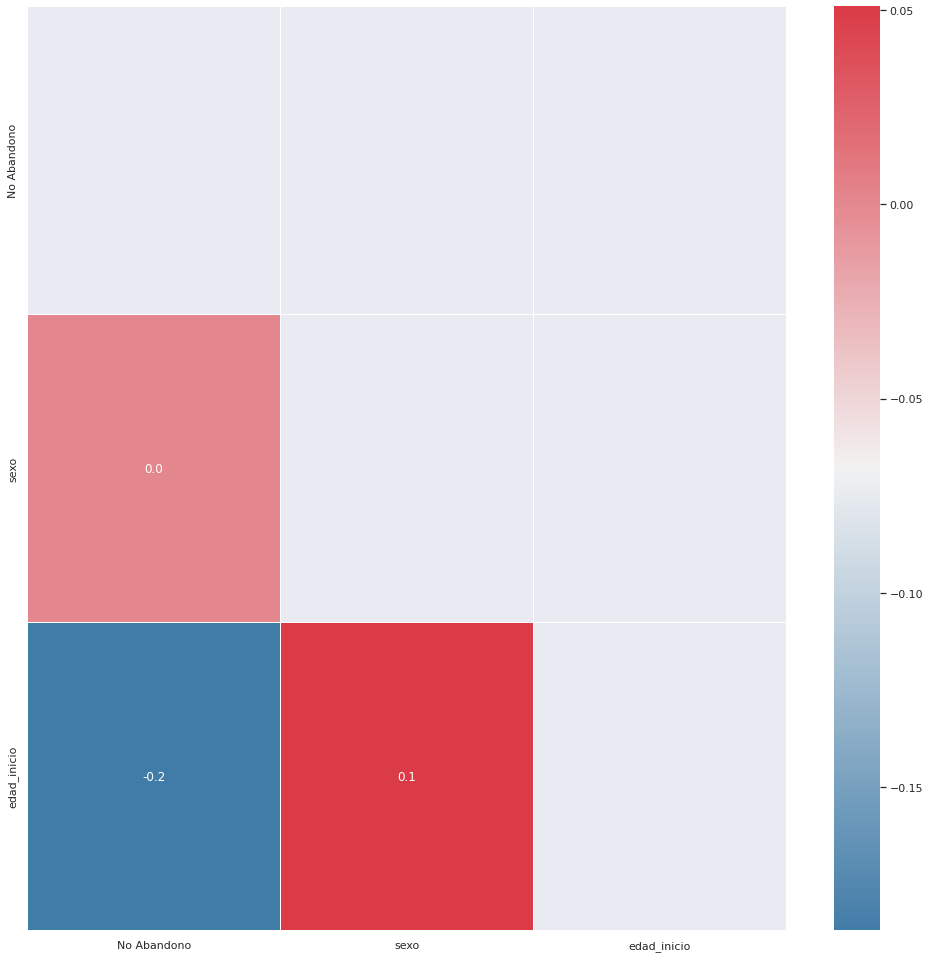

In [21]:
corr_heatmap(sexo_edad_data, data_y_dummie)

Se observa que hay una gran correlacion positiva entre el numero de veces que se rinde y el no abandonar

Creo una funcion para poder buscar las principales correlaciones con nuestro target

In [22]:
# Mediante esta funcion voy a tener ordenadas de mayor a menor las principales correlaciones ( positivas y negativas) 

def get_positive_corr_coefficient(data, target):
    data_dummie = pd.concat([target, data], axis=1)    
    positive_corr_df = data_dummie.corr(method='pearson')
    positive_corr_df = positive_corr_df.mask(np.tril(np.ones(positive_corr_df.shape)).astype(bool))
    positive_corr_df = positive_corr_df[abs(positive_corr_df) > 0.7].stack().reset_index().sort_values(by=0, ascending=False)
    positive_corr_df.rename(columns={0: "pearson_coefficient"}, inplace=True)
    return positive_corr_df

def get_negative_corr_coefficient(data, target):
    data_dummie = pd.concat([target, data], axis=1)    
    negative_corr_df = data_dummie.corr(method='pearson')
    negative_corr_df = negative_corr_df.mask(np.tril(np.ones(negative_corr_df.shape)).astype(bool))
    negative_corr_df = negative_corr_df[abs(negative_corr_df) < 0.3].stack().reset_index().sort_values(by=0)
    negative_corr_df.rename(columns={0: "pearson_coefficient"}, inplace=True)
    return negative_corr_df

In [23]:
# COrrelaciones positivas
positive_corr = get_positive_corr_coefficient(data_x, data_y_dummie)
positive_corr.head(10)

,level_0,level_1,pearson_coefficient
1533,n_psiquiatría,n_salud_publica_ii,0.976316
490,n_diagnostico_por_imagenes,n_salud_publica_ii,0.968018
1197,n_neurocirugia,n_salud_publica_ii,0.966271
486,n_diagnostico_por_imagenes,n_psiquiatría,0.966138
1548,n_salud_publica_i,n_salud_publica_ii,0.965317
1193,n_neurocirugia,n_psiquiatría,0.964241
143,n_bioetica_ii,n_salud_publica_ii,0.962619
141,n_bioetica_ii,n_salud_publica_i,0.962219
1380,n_oftalmologia,n_psiquiatría,0.959463
139,n_bioetica_ii,n_psiquiatría,0.956625


In [24]:
# Creo mascara para filtrar por las correlaciones solo con mi target

mask_corr_M = positive_corr["level_0"] == "No Abandono"

positive_corr_top10 = positive_corr.loc[positive_corr["level_0"] == "No Abandono"].head(10) #Tengo las principales features con correlacion para que sea maligno
positive_corr_top10

,level_0,level_1,pearson_coefficient
2,No Abandono,n_bioetica_ii,0.904848
51,No Abandono,n_salud_publica_ii,0.897319
49,No Abandono,n_salud_publica_i,0.891466
47,No Abandono,n_psiquiatría,0.882951
9,No Abandono,n_diagnostico_por_imagenes,0.879063
28,No Abandono,n_neurocirugia,0.878973
3,No Abandono,nota_bioetica_ii,0.864596
38,No Abandono,n_ortopedia_y_traumatologia,0.863435
36,No Abandono,n_oftalmologia,0.863435
7,No Abandono,n_dermatologia,0.862916


In [25]:
positive_corr_top10["level_1"].values

array(['n_bioetica_ii', 'n_salud_publica_ii', 'n_salud_publica_i',
       'n_psiquiatría', 'n_diagnostico_por_imagenes', 'n_neurocirugia',
       'nota_bioetica_ii', 'n_ortopedia_y_traumatologia',
       'n_oftalmologia', 'n_dermatologia'], dtype=object)

In [26]:
negative_corr = get_negative_corr_coefficient(data_x, data_y_dummie)
negative_corr.head(10)

,level_0,level_1,pearson_coefficient
139,edad_inicio,nota_patologia_ii,-0.265457
147,edad_inicio,nota_salud_publica_i,-0.258281
111,edad_inicio,nota_medicina_b,-0.253460
97,edad_inicio,nota_farmacologia_i,-0.250692
103,edad_inicio,nota_ginecologia,-0.248718
127,edad_inicio,nota_nutrición,-0.247924
101,edad_inicio,nota_fisiologia_y_biofisica,-0.247622
93,edad_inicio,nota_diagnostico_por_imagenes,-0.247043
129,edad_inicio,nota_obstetricia,-0.246892
141,edad_inicio,nota_pediatria,-0.246168


In [27]:
mask_corr_M = negative_corr["level_0"] == "No Abandono"

negative_corr_top10 = negative_corr.loc[negative_corr["level_0"] == "No Abandono"].head(10) 

negative_corr_top10

,level_0,level_1,pearson_coefficient
1,No Abandono,edad_inicio,-0.186999
0,No Abandono,sexo,0.001075
2,No Abandono,n_hist_biol_celular_embrio_y_gen,0.177462
3,No Abandono,n_micro_parasitologia_inmuno,0.287493
4,No Abandono,nota_micro_parasitologia_inmuno,0.289571


In [28]:
negative_corr_top10["level_1"].values


array(['edad_inicio', 'sexo', 'n_hist_biol_celular_embrio_y_gen',
       'n_micro_parasitologia_inmuno', 'nota_micro_parasitologia_inmuno'],
      dtype=object)

In [29]:
# Creo la variable "y" con mis etiquetas ya convertidas
y= data_y_dummie

# 5. Machine Learning

### 5.1 Funciones

In [30]:
def normalize_model(target, features_select):
    """
    Separa el target y lo normaliza
    """
    y = target
    X = features_select
    scaler = preprocessing.StandardScaler().fit(X)
    X = pd.DataFrame (scaler.transform(X))
    return X, y


def split_and_normalize_model(target, selected_data, ratio):
    """
    Separa mis muestras de entrenamiento y test
    """
    X, y = normalize_model(target, selected_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=1, stratify=y)

    print(f'Train Shape: {X_train.shape}')
    print(f'Test Shape: {X_test.shape}')
    return X_train, X_test, y_train, y_test

In [31]:
# RFECV 
from sklearn.feature_selection import RFECV

def get_best_features_by_RFECV(model, X_train, y_train, data):
    # Uso RFECV para elegir las mejores features
    selector = RFECV(estimator=model, step=1, 
                     cv=5, scoring='accuracy')
    selector = selector.fit(X_train, y_train)
    features_names = selector.get_support(1)
    best_features = data.columns[features_names]    
    print(f'Optimal number of features: {selector.n_features_}')
    print()
    print(f'Best features: \n')
    print(f'{best_features}')
    
    
    selected_features = selector.get_support(1)
    X_selected_features = data[data.columns[selected_features]]
    return X_selected_features

In [32]:
# Area bajo de la curva (AUC)

def auc_plot(xtest, ytest, model):
    yproba = model.predict_proba(xtest)
    fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
    auc = metrics.auc(fpr1, tpr1)
    print("El AUC es = " + str(auc))

    plt.plot(fpr1, tpr1, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(False)
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    plt.show()

In [33]:
# Matrix de confusion

def cm_plot(ytest, ypred):
    cm = confusion_matrix(ytest, ypred)
    df_cm = pd.DataFrame(cm, index = ['No Abandono', 'Abandono'], columns = ['No Abandono', 'Abandono'])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True)
    plt.title('Classification Confusion matrix')
    plt.show()

In [34]:
#Creo funcion para realizar accuracy y ademas guardarlo en una lista para poder compararlo mas adelante
from sklearn.metrics import accuracy_score

list_accuracy = {}

def accuracy_model(y_test, ypred, model=""):
    test_acc = accuracy_score(y_test_selec, ypred)
    list_accuracy[model] = round(test_acc,3)
    print("El accuracy es " + str(test_acc))

## 5.2 Modelos seleccionando features segun correlacion

Elijo las 10 variables con mayor correlacion positiva y negativa segun el ranking que realice

In [35]:
features_selec = ['edad_inicio', 'sexo', 'n_hist_biol_celular_embrio_y_gen', 'n_micro_parasitologia_inmuno', 'nota_micro_parasitologia_inmuno', 
                  'n_bioetica_ii', 'n_salud_publica_ii', 'n_salud_publica_i',
       'n_psiquiatría', 'n_diagnostico_por_imagenes', 'n_neurocirugia',
       'nota_bioetica_ii', 'n_ortopedia_y_traumatologia',
       'n_oftalmologia', 'n_dermatologia'] 

x_prueba = data_x.loc[:,features_selec]
x_prueba

,edad_inicio,sexo,n_hist_biol_celular_embrio_y_gen,n_micro_parasitologia_inmuno,nota_micro_parasitologia_inmuno,n_bioetica_ii,n_salud_publica_ii,n_salud_publica_i,n_psiquiatría,n_diagnostico_por_imagenes,n_neurocirugia,nota_bioetica_ii,n_ortopedia_y_traumatologia,n_oftalmologia,n_dermatologia
0,20.0,1,1,0,0.0,0,0,0,0,0,0,0.0,0,0,0
1,20.0,0,2,0,0.0,1,1,1,1,1,1,8.0,1,1,1
2,20.0,1,1,0,0.0,1,1,1,1,1,1,10.0,1,1,1
3,20.0,1,1,0,0.0,1,1,1,1,1,1,5.0,3,1,1
4,20.0,0,1,0,0.0,1,1,1,1,1,1,9.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,20.0,0,1,1,10.0,1,1,1,1,1,1,10.0,1,1,1
1752,19.0,1,1,1,9.0,1,1,1,1,1,1,9.0,1,1,1
1753,19.0,1,1,0,0.0,1,1,1,1,1,1,10.0,1,1,1
1754,19.0,1,1,1,8.0,1,1,1,1,1,1,7.0,1,1,1


## 5.2.1 Random Forest Classifier

In [36]:
# Split and normalize
#Ratio de 20% test y 80% train
X_train_selec, X_test_selec, y_train_selec, y_test_selec = split_and_normalize_model(y, x_prueba, 0.2)

Train Shape: (1205, 15)
Test Shape: (302, 15)


In [37]:
# Seleccionamos modelo
rf = RandomForestClassifier()

#Lo fiteamos
_rf = rf.fit(X_train_selec, y_train_selec)

#Predecimos
ypredrf = _rf.predict(X_test_selec)
ypredrf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [38]:
accuracy_model(y_test_selec, ypredrf, "RandomForest Classifier")

El accuracy es 0.9668874172185431


El AUC es = 0.9815873015873015


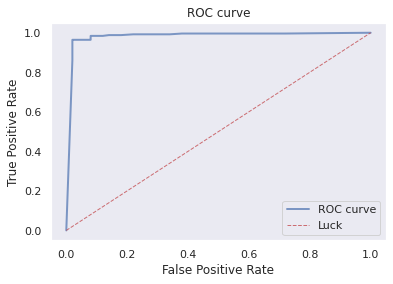

In [39]:
auc_plot(X_test_selec, y_test_selec, rf)

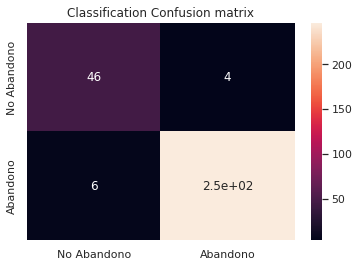

In [40]:
cm_plot(y_test_selec, ypredrf)

## 5.2.2 Logistic regression

In [41]:
# Creo variable para Logistic Regression

lr = LogisticRegression()

#Fit data train
_ = lr.fit(X_train_selec, y_train_selec)

# Realizo prediccion
ypred = _.predict(X_test_selec)
ypred

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [42]:
accuracy_model(y_test_selec, ypred, "Logistic_Regression")

El accuracy es 0.9735099337748344


El AUC es = 0.9812698412698413


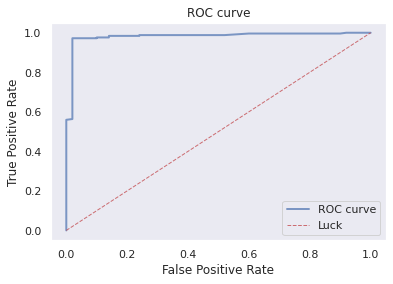

In [43]:
auc_plot(X_test_selec, y_test_selec, lr)

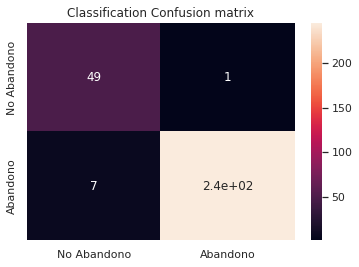

In [44]:
cm_plot(y_test_selec, ypred)

## 5.3  Modelos con GridSearch y Recursive Feature Elimination with Cross-validation (RFECV)

Utilizo Gridsearch apra encontrar los mejores hyperparametros y RFECV para las mejores features

In [45]:
# Primero split y normalizo mis datos con todas las features de nuevo

X_train_rf_rfecv, X_test_rf_rfecv, y_train_rf_rfecv, y_test_rf_rfecv = split_and_normalize_model(y, data_x, 0.2)

Train Shape: (1205, 76)
Test Shape: (302, 76)


## 5.3.1 Random Forest Classifier

### RFECV

In [46]:
# Realizo rfecv para encontrar las mejores features para Random Forest Classifier 

X_select_rfecv_rf =  get_best_features_by_RFECV(rf, X_train_rf_rfecv, y_train_rf_rfecv, data_x)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expe

Optimal number of features: 1

Best features: 

Index(['n_salud_publica_i'], dtype='object')


In [47]:
# Vuelvo a split y normalizar solo las features seleccionadas
X_train_rf_rfecv, X_test_rf_rfecv, y_train_rf_rfecv, y_test_rf_rfecv = split_and_normalize_model(y, X_select_rfecv_rf, 0.2)

Train Shape: (1205, 1)
Test Shape: (302, 1)


### GridSearch

In [48]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Hyperparametros
parameters = {'bootstrap': [True], 
            'max_depth': [5, 10, None], 
            'max_features': ['auto', 'log2'], 
            'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

clf_rf = GridSearchCV(rf, 
                   param_grid = parameters, 
                   refit = True, 
                   cv = 5,
                   verbose=0) 
                   

# Fit el modelo ya seleccionado
clf_rf.fit(X_train_rf_rfecv, y_train_rf_rfecv)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]})

In [49]:
# Observo cuales fueron los mejores hyperparametros

print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_rf.best_params_, clf_rf.best_score_))

Los mejores parametros fueron {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 5} con un score de 0.97


In [50]:
#Realizo prediccion con mi modelo ya entrenado

ypred_rfecv_rf = clf_rf.predict(X_test_rf_rfecv)
ypred_rfecv_rf

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [51]:
accuracy_model(y_test_rf_rfecv, ypred_rfecv_rf, "Random_Forest_Classifier_RFCV_GS")

El accuracy es 0.9668874172185431


El AUC es = 0.9642063492063493


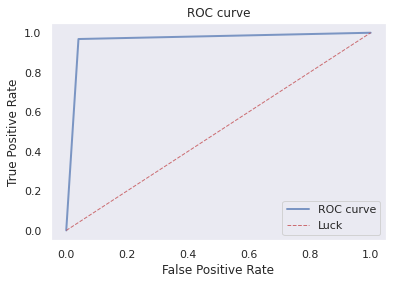

In [52]:
auc_plot(X_test_rf_rfecv, y_test_rf_rfecv, clf_rf)

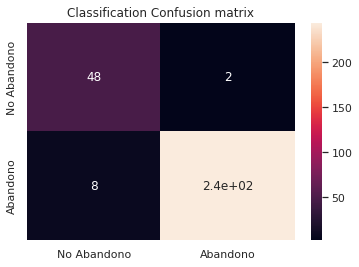

In [53]:
cm_plot(y_test_rf_rfecv, ypred_rfecv_rf)

## 5.2.2 Logistic regression

In [54]:
# Primero split y normalizo mis datos con todas las features 

X_train_lr_rfecv, X_test_lr_rfecv, y_train_lr_rfecv, y_test_lr_rfecv = split_and_normalize_model(y, data_x, 0.2)

Train Shape: (1205, 76)
Test Shape: (302, 76)


### RFECV

In [55]:
# Realizo rfecv para encontrar las mejores features para LR
lr = LogisticRegression()

X_select_rfecv_lr =  get_best_features_by_RFECV(lr, X_train_lr_rfecv, y_train_lr_rfecv, data_x)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Optimal number of features: 23

Best features: 

Index(['n_bioetica_i', 'nota_bioetica_i', 'n_bioetica_ii', 'n_cirugia',
       'nota_cirugia', 'nota_dermatologia', 'nota_farmacologia_i',
       'n_fisiologia_y_biofisica', 'nota_medicina_b', 'n_medicina_familiar_i',
       'nota_medicina_familiar_i', 'n_micro_parasitologia_inmuno',
       'n_neurocirugia', 'n_neurología', 'nota_neurología',
       'n_ortopedia_y_traumatologia', 'nota_otorrinolaringología',
       'n_pediatria', 'nota_psiquiatría', 'n_salud_mental',
       'nota_salud_mental', 'n_salud_publica_i', 'n_salud_publica_ii'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
# Vuelvo a split y normalizar solo las features seleccionadas
X_train_lr_rfecv, X_test_lr_rfecv, y_train_lr_rfecv, y_test_lr_rfecv = split_and_normalize_model(y, X_select_rfecv_lr, 0.2)

Train Shape: (1205, 23)
Test Shape: (302, 23)


### GridSearch

In [57]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Hyperparametros
parameters = {'penalty':['l1', 'l2'], 
                 'C': [100, 10, 1.0, 0.1, 0.01],
                 'solver': ['liblinear']}
# 
clf_lr = GridSearchCV(lr, # modelo
                   param_grid = parameters, # Hyperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                   cv = 5,
                   verbose=0) # cv indica la cantidad de folds
                   

# Fit el modelo ya seleccionado
clf_lr.fit(X_train_lr_rfecv, y_train_lr_rfecv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [58]:
# Observo cuales fueron los mejores hyperparametros

print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_lr.best_params_, clf_lr.best_score_))

Los mejores parametros fueron {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} con un score de 0.97


In [59]:
#Realizo prediccion con mi modelo ya entrenado

ypred_rfecv_lr = clf_lr.predict(X_test_lr_rfecv)
ypred_rfecv_lr

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [60]:
accuracy_model(y_test_lr_rfecv, ypred_rfecv_lr, "Logistic_regression_RFCV_GS")

El accuracy es 0.9635761589403974


El AUC es = 0.9791666666666667


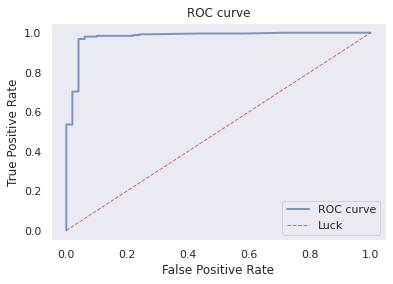

In [61]:
auc_plot( X_test_lr_rfecv, y_test_lr_rfecv, clf_lr)


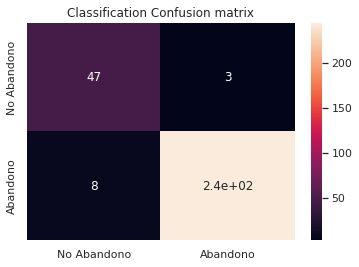

In [62]:
cm_plot(y_test_lr_rfecv, ypred_rfecv_lr)

## 6. Score

In [63]:
modelos= list(list_accuracy.keys())
score= list(list_accuracy.values())

list_accurary_score = pd.DataFrame({"Modelos": modelos, "Accuracy": score})

list_accurary_score.sort_values(by="Accuracy", ascending=False)

,Modelos,Accuracy
1,Logistic_Regression,0.974
0,RandomForest Classifier,0.967
2,Random_Forest_Classifier_RFCV_GS,0.967
3,Logistic_regression_RFCV_GS,0.964
